In [7]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

In [8]:
df = get_dax_data()

In [9]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [10]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-12-18,16650.550781,-0.604090,-0.608812,-0.691276,-0.844382,-0.860397
2023-12-19,16744.410156,0.562118,-0.041971,-0.046693,-0.129157,-0.282263
2023-12-20,16733.050781,-0.067863,0.494256,-0.109834,-0.114556,-0.197020
2023-12-21,16687.419922,-0.273071,-0.340934,0.221184,-0.382905,-0.387627
2023-12-22,16706.179688,0.112355,-0.160716,-0.228579,0.333540,-0.270550


In [11]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [40]:
from DAX.Models.arma_garch_11 import arma_garch_11
from DAX.Models.garch11 import garch11, garch11_t
from DAX.Models.baseline_100 import baseline_100
from DAX.Models.baseline_300 import baseline_300

models = [
    # {
    #     'name': 'baseline',
    #     'function': baseline
    # },
    # {
    #     'name': 'garch11_t',
    #     'function': garch11_t
    # },
    {
        'name': 'arma_garch_11',
        'function': arma_garch_11
    },
    # {
    #     'name': 'baseline_armagarch11',
    #     'function': [[baseline, arma_garch_11],[0.5,0.5]]
    #  },
    # {
    #     'name': 'baseline_300',
    #     'function': baseline_300
    #  },
    # {
    #     'name': 'baseline_100',
    #     'function': baseline_100
    #  },
]


In [41]:
evaluate_models(models, df, 150, weeks=True)

*********** Start the evaluation of Model arma_garch_11 ***********
Iteration 1 of 150
Iteration 2 of 150
Iteration 3 of 150
Iteration 4 of 150
Iteration 5 of 150
Iteration 6 of 150
Iteration 7 of 150
Iteration 8 of 150
Iteration 9 of 150
Iteration 10 of 150
Iteration 11 of 150
Iteration 12 of 150
Iteration 13 of 150
Iteration 14 of 150
Iteration 15 of 150
Iteration 16 of 150
Iteration 17 of 150
Iteration 18 of 150
Iteration 19 of 150
Iteration 20 of 150
Iteration 21 of 150
Iteration 22 of 150
Iteration 23 of 150
Iteration 24 of 150
Iteration 25 of 150
Iteration 26 of 150
Iteration 27 of 150
Iteration 28 of 150
Iteration 29 of 150
Iteration 30 of 150
Iteration 31 of 150
Iteration 32 of 150
Iteration 33 of 150
Iteration 34 of 150
Iteration 35 of 150
Iteration 36 of 150
Iteration 37 of 150
Iteration 38 of 150
Iteration 39 of 150
Iteration 40 of 150
Iteration 41 of 150
Iteration 42 of 150
Iteration 43 of 150
Iteration 44 of 150
Iteration 45 of 150
Iteration 46 of 150
Iteration 47 of 150
I

In [42]:
import numpy as np


model_index = 0
results = []

models[0]['evaluation'] = models[0]['evaluation'].dropna()

for h in [f'{h} day' for h in [1, 2, 5, 6, 7]]:
    results.append(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == h])

# results36h = models[0]['evaluation'][models[0]['evaluation']['horizon'] == '36 hour']



# results = models[0]['evaluation']



## Create PIT Histogram

FileNotFoundError: [Errno 2] No such file or directory: 'plots/0 PP5C.png'

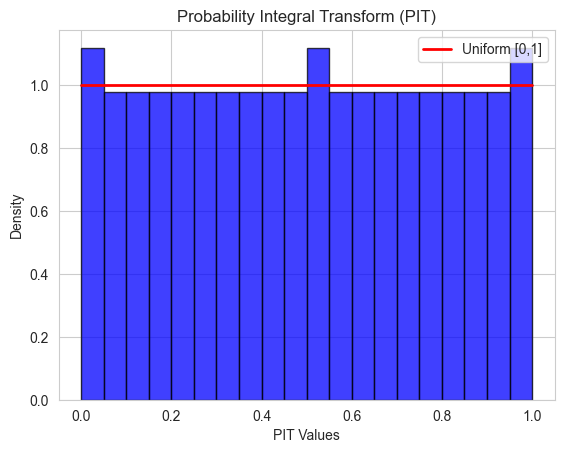

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import string
import random
import scipy.stats as stats

from scipy.stats import uniform

for index, r in enumerate(results):
    obs = np.array(np.array(r['observation']),dtype=float)
    forecasts = np.array(np.array(r.loc[:,'q0.025':'q0.975']),dtype=float)

    # Example quantile forecasts and observations
    quantile_forecasts = forecasts
    observations = obs
    
    # Calculate PIT values
    pit_values = np.zeros_like(quantile_forecasts)
    
    for i in range(quantile_forecasts.shape[1]):
        sorted_forecasts = np.sort(quantile_forecasts[:, i])
        ecdf_values = np.linspace(0, 1, len(sorted_forecasts))
        pit_values[:, i] = np.interp(
            quantile_forecasts[:, i], sorted_forecasts, ecdf_values)
    
    # Create PIT histogram
    fig, ax = plt.subplots()
    ax.hist(pit_values.flatten(), bins=20, density=True,
            alpha=0.75, color='blue', edgecolor='black')
    
    # Plot the uniform distribution for reference
    x = np.linspace(0, 1, 100)
    ax.plot(x, uniform.pdf(x), 'r-', lw=2, label='Uniform [0,1]')
    
    ax.set_title('Probability Integral Transform (PIT)')
    ax.set_xlabel('PIT Values')
    ax.set_ylabel('Density')
    ax.legend()
    
    
    plt.savefig(f'../plots/{index} {"".join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(4))}.png')
    plt.show()

## Check Manually

In [44]:
array = []

for q in ['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']:
    # print(f'*** {q} ***')
    # arr = models[5]['evaluation'][q] > models[5]['evaluation']['gesamt']
    # print(arr.mean())
    
    per_quantile = []
    
    
    for index, r in enumerate(results):
        # r.loc[:, f'{q}larger'] = r[q] > r['gesamt']
        mean = (r[q] > r['observation']).mean()
        # print(r[f'{q}larger'].mean())
        per_quantile.append(round(mean,3))
    per_quantile.append(round((models[model_index]['evaluation'][q] > models[model_index]['evaluation']['observation']).mean(), 3))
    
    array.append(per_quantile)
        
pd.DataFrame(array, columns=['1 day', '2 day', '5 day', '6 day', '7 day', 'All horizons'], index=['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975'])



,1 day,2 day,5 day,6 day,7 day,All horizons
q0.025,0.007,0.035,0.007,0.007,0.013,0.014
q0.25,0.203,0.215,0.227,0.200,0.227,0.214
q0.5,0.531,0.535,0.567,0.553,0.547,0.547
q0.75,0.895,0.833,0.813,0.807,0.820,0.833
q0.975,1.000,1.000,1.000,1.000,0.993,0.999
